In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.models import Model
import cv2

%matplotlib inline

## Load VGG model

In [3]:
from tensorflow.python.keras.applications.vgg19 import VGG19

In [4]:
model = VGG19(include_top = False,
              weights = 'imagenet')
model.trainable = False
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

## Content_layer and Style_layers

In [5]:
content_layer = 'block5_conv1'

style_layers = ['block1_conv2',
               'block2_conv2',
               'block3_conv2',
               'block4_conv2',
               'block5_conv2']

style_wts = 0.2

## Helper funtions

In [6]:
from tensorflow.python.keras.applications.vgg19 import preprocess_input
## Load an image and return it as a numpy array of floating-points. 
## The image can be automatically resized so the largest of the height or width equals max_size.
def load_image(filename, max_size=None):
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.array(image)
    
    if max_size is not None:
        dim = max_size
        
        # Resize the image.
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        
    # Expand the dims of image to the dims the model expects
    image = reshape_and_normalize(image)
    
    # Convert to numpy floating-point array.
    return image

In [7]:
def reshape_and_normalize(image):
    """
    Reshape and normalize the input image (content or style)
    """
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

    # Reshape image to mach expected input of VGG16
    image = np.reshape(image, ((1,) + image.shape))
    
    # Substract the mean to match the expected input of VGG16
    image = image - means
    
    return image

def deprocess(image):
    # perform the inverse of the preprocessiing step
    means = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
    image = image + means
    
    image = np.clip(image, 0, 255).astype('uint8')
    return image

In [71]:
## Plot a large image. The image is given as a numpy array with pixel-values between 0 and 255.
def save_image(image, filename, shape=None):
    
    image = deprocess(image)

    if len(image.shape) == 4:
        image = np.squeeze(image, axis=0)

    if shape is not None:
        ## Upscale Image
        dim = shape
        image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    
    # Convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Ensure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # Convert to bytes.
    image = image.astype(np.uint8)
    
    # Write the image-file in jpeg-format.
    cv2.imwrite(filename, image)

In [9]:
def plot_image(image):
    
    # Deprocess image
    image = deprocess(image)

    if len(image.shape) == 4:
        image = np.squeeze(image, axis=0)
      
    # Display image.
    plt.imshow(image)

In [10]:
## Plot the content-, mixed- and style-images.
def plot_images(content_image, style_image, mixed_image):
        
    # Deprocess image
    content_image = deprocess(content_image)
    style_image = deprocess(style_image)
    mixed_image = deprocess(mixed_image)

    if len(content_image.shape) == 4:
        content_image = np.squeeze(content_image, axis=0)
    if len(style_image.shape) == 4:
        style_image = np.squeeze(style_image, axis=0)
    if len(mixed_image.shape) == 4:
        mixed_image = np.squeeze(mixed_image, axis=0)
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(20, 20))

    # Adjust vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # Plot the content-image.
    # Note that the pixel-values are normalized to
    # the [0.0, 1.0] range by dividing with 255.
    ax = axes.flat[0]
    ax.imshow(content_image, interpolation=interpolation)
    ax.set_xlabel("Content")

    # Plot the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image , interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # Plot the style-image
    ax = axes.flat[2]
    ax.imshow(style_image , interpolation=interpolation)
    ax.set_xlabel("Style")

    # Remove ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Content Cost

In [11]:
def content_cost(model, content_layer, content, generated):
    
    J_content = 0;
        
    # Select the output tensor of the currently selected layer
    content_model = Model(inputs = model.input, ## Same input as vgg19 model
                      outputs = model.get_layer(content_layer).output) ## We call the Vgg model and we get the layer the has the name 'layer'.
        
    a_C = content_model(content)
    a_G = content_model(generated)
    
    J_content = tf.reduce_mean(tf.square(a_C - a_G))
        
    return J_content

## Style Cost

In [12]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    GA = tf.matmul(A, tf.transpose(A))
    
    return GA

In [13]:
def style_layer_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost 
    """
    
    # Retrieve dimensions from a_G 
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, ([n_H*n_W, n_C])))
    a_G = tf.transpose(tf.reshape(a_G, ([n_H*n_W, n_C])))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    #J_style_layer = 1./(4*n_C**2 *(n_H*n_W)**2)*tf.reduce_sum(tf.pow((GS - GG), 2))
    
    J_style_layer = tf.reduce_mean(tf.square(GS - GG))
    
    return J_style_layer

In [14]:
def style_cost(model, style_layers, style, generated):
    
    J_style = 0;
    
    for layer in style_layers:
        
        # Select the output tensor of the currently selected layer
        style_model = Model(inputs = model.input, ## Same input as vgg19 model
                      outputs = model.get_layer(layer).output) ## We call the Vgg model and we get the layer the has the name 'layer'.
        
        a_S = style_model(style)
        a_G = style_model(generated)
        
        J_style += style_layer_cost(a_S, a_G) * style_wts
        
    return J_style

## Total Cost

In [15]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost
    """
    J = alpha*J_content + beta*J_style
    
    return J

## Load Images

In [62]:
content_path = 'football.jpg'
shape = (720, 480)
content = load_image(content_path, shape)

#content_height = content.shape[1]
#content_width = content.shape[2]
#shape = (content_width, content_height)

#plot_image(content)

In [63]:
style_path = 'The Scream.jpg'
style = load_image(style_path, shape)

#plot_image(style)

In [64]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (1, shape[1], shape[0], 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return tf.Variable(input_image, dtype=np.float32)

## Training

In [66]:
import time 
generated_images = []

def training_loop(model, content_layer, style_layers, content, style, iterations=20):
    
    # we can use a random image for generated image 
    # but we wil arrive much quicker 
    # at a solutiion if we used the contenet image 
    # as the start for generated image
    generated = generate_noise_image(content)

    optimizer = tf.keras.optimizers.Adam(learning_rate = 2.)
    # AS our loop wil run, we will store the corresponding best cost and best image
    best_cost = 1e20 + 0.1
    best_image = None
    
    start_time = time.time()
    for i in range(iterations):
        with tf.GradientTape() as tape:
            
            J_content = content_cost(model, content_layer, content, generated)
            J_style = style_cost(model, style_layers, style, generated)
            J_total = total_cost(J_content, J_style, 10, 40)
            
        # Determine the gradients of the loss function w.r.t the image pixels
        grads = tape.gradient(J_total, generated)
        # Update the pixels
        optimizer.apply_gradients([(grads, generated)])
        
        if J_total < best_cost:
            best_cost = J_total
            best_image = generated.numpy()
            
        if i%4 == 0:
            print('Cost total: {}. Content cost: {}. Style cost: {}. Time elapsed: {}'.format(J_total, J_content, J_style, time.time() - start_time))
            generated_images.append(generated.numpy())
        
    return best_image

In [67]:
best_image = training_loop(model, content_layer, style_layers, content, style, iterations=200)

Cost total 0: 1.6728157789531018e+21. Content cost: 3370.318603515625. Style cost: 4.182039535343685e+19. Time elapsed: 1.5330584049224854
Cost total 4: 1.5774226427084653e+21. Content cost: 3793.307373046875. Style cost: 3.943556782693024e+19. Time elapsed: 4.5881547927856445
Cost total 8: 1.4542670665609034e+21. Content cost: 4209.92529296875. Style cost: 3.6356675784413282e+19. Time elapsed: 7.642445802688599
Cost total 12: 1.3194609596523107e+21. Content cost: 4665.8798828125. Style cost: 3.298652531072172e+19. Time elapsed: 10.699115753173828
Cost total 16: 1.178774277530279e+21. Content cost: 5213.19189453125. Style cost: 2.9469356938256974e+19. Time elapsed: 13.75360631942749
Cost total 20: 1.0164703171968688e+21. Content cost: 5854.1279296875. Style cost: 2.5411758809531023e+19. Time elapsed: 16.810174465179443
Cost total 24: 8.168404527830679e+20. Content cost: 6541.5419921875. Style cost: 2.042101175938135e+19. Time elapsed: 19.866403102874756
Cost total 28: 5.903526683040012

## Plot the Results

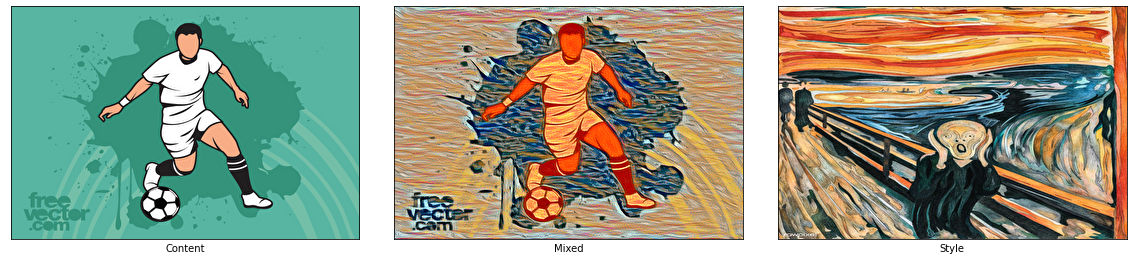

In [72]:
plot_images(content, style, best_image)

In [73]:
save_image(best_image, 'Football_Scream.jpg', shape)